# Code metrics analysis

This notebooks demonstrates how to use __[codemetrics](https://github.com/elmotec/codemetrics)__ to gain insight on a code base.

In [1]:
import os
import os.path
import datetime as dt
import textwrap
import json
import pathlib as pth

import joblib
import pandas as pd
import numpy as np
import altair as alt
from altair.vega.v4 import Vega
from tqdm import tqdm

import codemetrics as cm
import codemetrics.vega

%matplotlib inline

%load_ext autoreload
%autoreload

## Setup

Sets up a few useful things:
    - define a few useful variables like `year_ago` 
    - change directory to the location of the project being analyzed.
    - joblib.Memory to cache some outputs and clearing out the cache when we execute this cell.


In [2]:
# Useful variables
year_ago = dt.datetime.now(tz=dt.timezone.utc) - dt.timedelta(365)

# Change current directory to the project under being analyzed.
target_location = pth.Path.home() / 'Documents' / 'Github' / 'pandas'
cwd = os.path.abspath(os.path.curdir)
os.chdir(target_location)

# Sets up caching and wipes out cache if any.
disk = joblib.Memory(location=os.getenv('TEMP'), verbose=0)
get_cloc = disk.cache(cm.get_cloc)
get_git_log = disk.cache(cm.get_git_log)
get_cloc.clear()
get_git_log.clear()

## Lines of code (loc)

Leverage cloc to count the lines of code and infer some basic information about the languages used in this project.

In [3]:
cloc_program = str(pth.Path.home() / 'scripts' / 'cloc-1.64.exe')
print(cloc_program)
loc = get_cloc(cloc_program=cloc_program)

C:\Users\jlecomte\scripts\cloc-1.64.exe


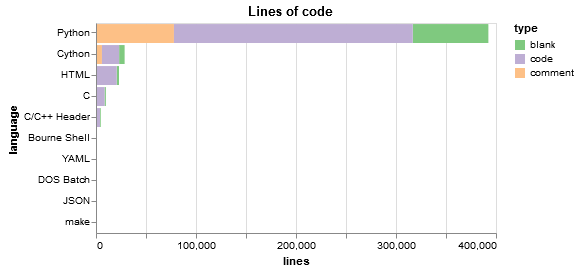

In [4]:
loc_sum = loc.groupby('language').sum().reset_index().melt(id_vars=['language']).rename(columns={'variable': 'type', 'value': 'lines'})
alt.Chart(loc_sum).mark_bar().encode(
    x=alt.X('lines:Q'),
    y=alt.Y('language:N', sort=alt.EncodingSortField(field='lines', op='sum', order='descending')),
    color=alt.Color('type:N', scale=alt.Scale(scheme='accent')), 
    tooltip=['lines:Q', 'type:O'],
).properties(title='Lines of code')

## Retrieve git log data

Now that we know what the code base looks like today, we turn our attention to history and build a data frame of the git log history for the past year. 

We then calculate the age of each file and generate a graph of recent changes as well as a circle visualization of the code base. 

In [5]:
log = get_git_log(path='.', after=year_ago, git_client='git.exe')
log['issue'] = log['message'].str.extract(r'\(#(\d+)\)')
log = pd.merge(log, loc[['path']], left_on='path', right_on='path')

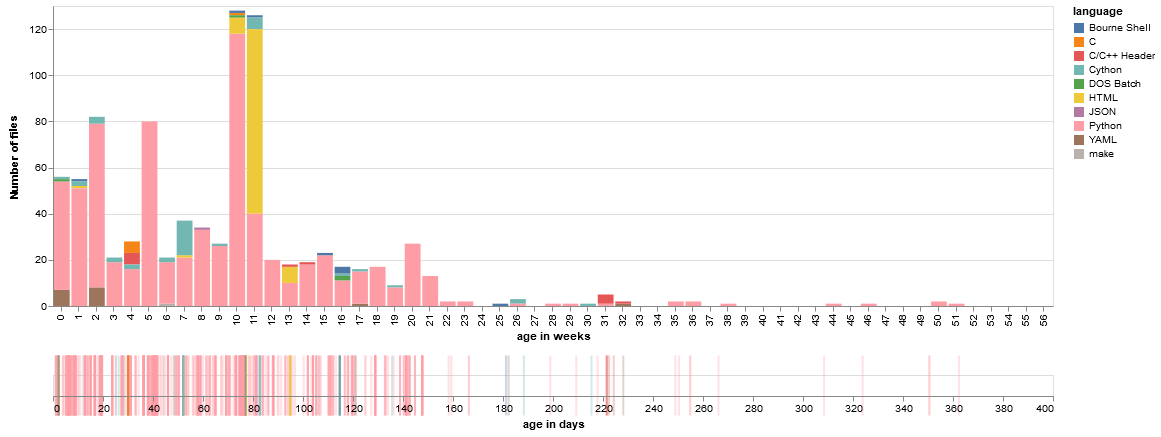

In [8]:
ages = cm.get_ages(log).merge(loc)
ages['last_change'] = ages['age'].apply(lambda a: pd.to_datetime('today') - dt.timedelta(a))
ages['age_in_week'] = ages['age'].apply(lambda d: int(d / 7))

width = 1000
weeks = list(range(int(400 / 7)))
chart = alt.Chart(ages).encode(color='language')
top = chart.mark_bar().\
    encode(x=alt.X('age_agg:O', sort='ascending', title='age in weeks', scale=alt.Scale(domain=weeks)),
           y=alt.Y('count(path):Q', title='Number of files'),
           color=alt.Color('language', scale=alt.Scale(scheme='tableau10')),
           tooltip=['count(path)', 'language']
          ).\
    transform_calculate(age_agg='floor(datum.age / 7)').\
    properties(width=width)
bottom = chart.mark_tick(size=60, thickness=2, opacity=.3).\
    encode(x=alt.X('age:Q', title='age in days'),
           tooltip='path').properties(width=width)
alt.vconcat(top, bottom)

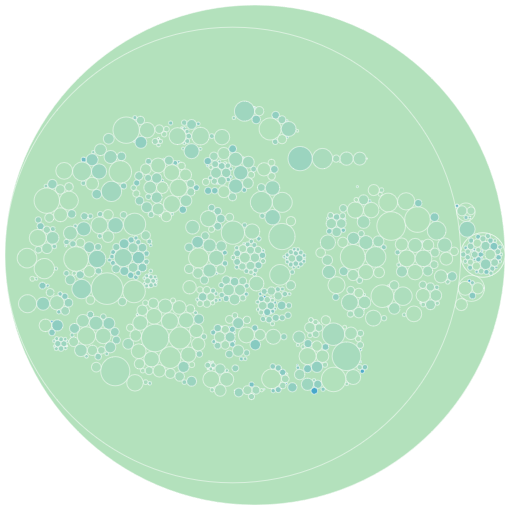

In [9]:
code_ages = ages.query("path.str.endswith('.py') | path.str.endswith('.c')")
desc = cm.vega.vis_ages(code_ages, height=500, width=500)
Vega(desc)

## Complexity

On to complexity calculation. Here we calculate the complexity of the current code base, file by file,
function by function so it could take a little long. We run it on .py files only and we leverage tqdm to
show a progress bar.

In [10]:
# Get Python file with the most recent revision
python_df = log[['path', 'date']].groupby('path', as_index=False).\
                max().query("path.str.endswith('.py')").\
                merge(log[['path', 'date', 'revision']])
# Progress bar for pandas
tqdm.pandas(desc="calculating")
# Calculates complexity on python files.
complexity = python_df[['revision', 'path']].groupby(['revision', 'path']).\
    progress_apply(cm.get_complexity, download_func=cm.git.download)

calculating: 100%|███████████████████████████████████████████████████████████████████| 718/718 [00:58<00:00, 12.50it/s]


In [11]:
# Calculates 80% percentile of complexity for each file
path_complexity = complexity.reset_index()[['path', 'cyclomatic_complexity', 'token_count']].\
    groupby('path').quantile(.8).sort_values(by='cyclomatic_complexity', ascending=False).\
    reset_index().rename(columns={'cyclomatic_complexity': 'complexity'})
# Merge to lines of code. 
loc_cc = pd.merge(loc, path_complexity)

# Hot spots

Hot spots are files that exhibit high complexity __and__ changed a lot recently. This is typically where you will find bugs.

The graph below will show files harboring complexity as large circle while an increased number of change will make the color trend from yellow to more red shades.

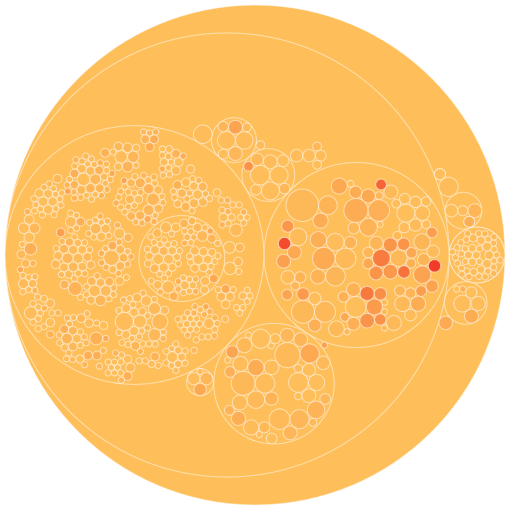

In [12]:
hspots = cm.get_hot_spots(log, loc_cc) 
hspots.query("language == 'Python'").sort_values(by=['changes', 'complexity'], ascending=False).head()
desc = cm.vega.vis_hot_spots(hspots, width=500, height=500, size_column='complexity')
Vega(desc)

## Co-changes or inter-file coupling

Co-changes builds on the idea that files or functions that change together imply a hidden dependency and may need refactoring.

We calculate how often each file change in relation to the other and display high level of coupling. Again, we focus on the files that have changed a lot recently.

In [13]:
co_changes = cm.get_co_changes(log, by='path', on='issue').\
    query("(coupling > .6) & (changes > 20)").\
    sort_values(by=['changes', 'cochanges'], ascending=False)
co_changes

,path,dependency,changes,cochanges,coupling
7736,pandas/core/arrays/datetimelike.py,pandas/core/arrays/datetimes.py,67,43,0.641791
7739,pandas/core/arrays/datetimelike.py,pandas/core/arrays/period.py,67,41,0.611940
8591,pandas/core/arrays/period.py,pandas/core/arrays/datetimes.py,65,42,0.646154
8590,pandas/core/arrays/period.py,pandas/core/arrays/datetimelike.py,65,41,0.630769
15848,pandas/core/indexes/timedeltas.py,pandas/core/indexes/datetimes.py,58,46,0.793103
8998,pandas/core/arrays/timedeltas.py,pandas/core/arrays/datetimes.py,52,40,0.769231
17285,pandas/core/panel.py,pandas/core/frame.py,33,23,0.696970
112476,scripts/validate_docstrings.py,scripts/tests/test_validate_docstrings.py,28,20,0.714286
31591,pandas/tests/arrays/test_datetimelike.py,pandas/core/arrays/datetimes.py,26,19,0.730769
36406,pandas/tests/extension/decimal/test_decimal.py,pandas/tests/extension/json/test_json.py,24,17,0.708333


## File level analysis

It can also be useful to dive into the complexity history of one particular file or function. Let's consider the following file and calculate historical complexity of each function in the file. 

In [14]:
path = 'pandas/core/frame.py'
func_df = log[log['path'] == path][['date', 'revision', 'path']]
func_df.head()

,date,revision,path
238,2019-03-18 12:23:51+00:00,a703313ba,pandas/core/frame.py
239,2019-03-14 15:26:14+00:00,64f596179,pandas/core/frame.py
240,2019-03-10 21:08:24+00:00,34e8efeaa,pandas/core/frame.py
241,2019-03-05 22:15:19+00:00,615fbb3ce,pandas/core/frame.py
242,2019-03-01 01:46:43+00:00,0a61ecdf6,pandas/core/frame.py


In [15]:
func_cplx_df = func_df.groupby(['revision', 'path']).progress_apply(cm.get_complexity, download_func=cm.git.download)

calculating: 100%|███████████████████████████████████████████████████████████████████| 198/198 [00:36<00:00,  5.44it/s]


In [17]:
func_cpx_df = pd.merge(func_df, func_cplx_df.reset_index(), on=['revision', 'path'])
top_cpx_func_df = func_cpx_df.groupby('name')[['cyclomatic_complexity']].mean().nlargest(8, 'cyclomatic_complexity')
filt_func_cpx_df = func_cpx_df[func_cpx_df['name'].isin(set(top_cpx_func_df.index))]
filt_func_cpx_df.head()

,date,revision,path,function,cyclomatic_complexity,nloc,token_count,name,long_name,start_line,end_line,top_nesting_level,length,fan_in,fan_out,general_fan_out,file_tokens,file_nloc
22,2019-03-18 12:23:51+00:00,a703313ba,pandas/core/frame.py,22,17,38,383,to_dict,"to_dict( self , orient = 'dict' , into = dict )",1179,1305,1,127,0,0,0,18560,3203
26,2019-03-18 12:23:51+00:00,a703313ba,pandas/core/frame.py,26,14,41,238,from_items,"from_items( cls , items , columns = None , ori...",1729,1814,1,86,0,0,0,18560,3203
48,2019-03-18 12:23:51+00:00,a703313ba,pandas/core/frame.py,48,17,36,278,__getitem__,"__getitem__( self , key )",2839,2897,1,59,0,0,0,18560,3203
68,2019-03-18 12:23:51+00:00,a703313ba,pandas/core/frame.py,68,25,44,417,_sanitize_column,"_sanitize_column( self , key , value , broadca...",3528,3631,1,104,0,0,0,18560,3203
105,2019-03-18 12:23:51+00:00,a703313ba,pandas/core/frame.py,105,13,43,312,combine,"combine( self , other , func , fill_value = No...",5149,5315,1,167,0,0,0,18560,3203


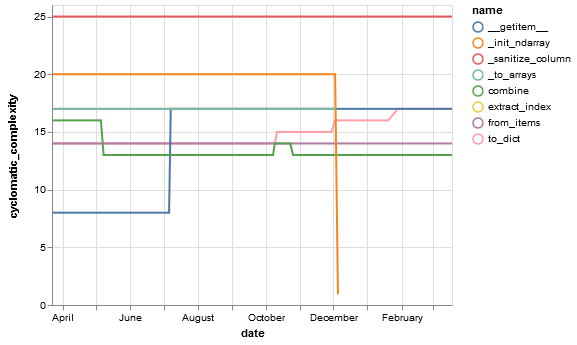

In [18]:
alt.Chart(filt_func_cpx_df).\
    mark_line().encode(
        x='date:T',
        y='cyclomatic_complexity:Q',
        color='name:N',
        tooltip=['name', 'revision']
    )

To be continued...